In [1]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import pickle
import pandas as pd

from abc import ABC, abstractmethod
import time, random, itertools
from typing import Callable, Tuple, List, Optional
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import tqdm

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.ra import *
set_seed(313)

In [2]:

def perthomeo_exp(random_seed=313):
    save_dir = "experiments/homeopert_ring"
    set_seed(random_seed)
    homeo_type = 'node'
    layer_sizes = 1*[128]
    homeo_mean = 0.02  #0.02
    homeo_std = 0.5 #0.25
    dim=2
    target_homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'init_type': 'small', 'activation': nn.ReLU, 'init_mean': homeo_mean, 'init_std': homeo_std}
    target_homeo = build_homeomorphism(target_homeo_params)
    save_homeo_ds_net(target_homeo, f"{save_dir}/target_homeo.pth")

    dt=.2
    time_span = torch.tensor([0.0, 2.]) 
    train_ratio = 0.8
    ds_motif = 'ring' 
    analytic = True
    vf_on_ring_enabled = True #if analytic then not used
    training_pairs = False
    alpha_init = None
    if training_pairs:
        time_span = torch.tensor([0.0, dt])
    ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
    simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0,
                        'training_pairs': training_pairs, 'margin': 0.5, 'seed': 42, 'train_ratio': train_ratio, 'ds_params': ds_params}
    
    homeo_type = 'node'
    layer_sizes = 1*[128]
    init_type = None
    homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': init_type}

    lr = 0.01
    num_epochs = 1000
    annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
    training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32,
                    'use_inverse_formulation': True}
    
    all_parameters = {'target_homeo_params': target_homeo_params, 'homeo_params': homeo_params, 'training_params': training_params, 'simulation_params': simulation_params}
    with open("parameters.pkl", "wb") as f:
        pickle.dump(all_parameters, f)
    
    # generate ring attractor trajectories
    generator_ra = AnalyticalRingAttractor(dim=dim, dt=dt, time_span=time_span) 
    # generator_ra = LearnableNDRingAttractor(dim=dim, dt=dt, time_span=time_span, noise_std=simulation_params['noise_std'])
    init_conds = prepare_initial_conditions(mode=simulation_params['initial_conditions_mode'], num_points=simulation_params['number_of_target_trajectories'], margin=simulation_params['margin'], seed=simulation_params['seed'])
    ra_trajs = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32))

    B = ra_trajs.shape[0]
    n_train = int(train_ratio * B)
    n_test = B - n_train

    results = []
    for interpol_value_i, interpol_value in enumerate(np.linspace(0, 1, 11)):
        interpol_value = round(interpol_value, 2)
        print(f"Interpol value: {interpol_value}")

        interpolated_homeo = rescale_node_vf(target_homeo, interpol_value)
        target_jacobian_norm = jacobian_norm_over_batch(interpolated_homeo, ra_trajs.reshape(-1,dim))

        trajectories_target_full = interpolated_homeo(ra_trajs)
        trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target_full, simulation_params['training_pairs'])
        np.save(f"trajectories_target_{interpol_value}.npy", trajectories_target_full.detach().numpy())

        train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
        trajectories_target_train = trajectories_target[train_set.indices]
        trajectories_target_test = trajectories_target[test_set.indices]

        target_ra_points = get_homeo_invman(interpolated_homeo) 
        target_ra_points = (target_ra_points - mean.detach().numpy()) / std.detach().numpy() 

        homeo = build_homeomorphism(homeo_params)
        source_system_ra = build_ds_motif(**ds_params)
        homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
        homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
        homeo_ds_net.eval()
        
        _, _, training_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train)
        _, _, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
        traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)

        
        fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
        jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim))

        results.append({
            "interpol_value": interpol_value,
            "train_loss": training_loss,
            "test_loss": test_loss,
            "jacobian_norm": jac_norm,
            "target_jacobian_norm": target_jacobian_norm,
            "losses": losses,
            "grad_norms": grad_norms,
            "fit_ra_points": fit_ra_points,
            "target_ra_points": target_ra_points[0],
        })

        save_homeo_ds_net(homeo_ds_net, f"{save_dir}/homeo_{interpol_value}.pth")
        np.save(f"{save_dir}/traj_motif_transformed_{interpol_value}.npy", traj_trans_np) #save trajectories_motif 
        np.save(f"{save_dir}/traj_motif_source_{interpol_value}.npy", traj_src_np) #save trajectories_motif directly from the source 

    df = pd.DataFrame(results)
    df.to_pickle(f"{save_dir}/summary_df.pkl")

In [3]:
#perthomeo_exp() #run time: 1h 28m

In [4]:
#load data
save_dir_homeo = "experiments/homeopert_ring"
df = pd.read_pickle(f"{save_dir_homeo}/summary_df.pkl")

In [5]:
###test models
# for i, row in df.iterrows():
#     interpol_value = row['interpol_value']
#     all_parameters = pickle.load(open("experiments/homeopert_ring/parameters.pkl", "rb"))
#     layer_sizes = all_parameters['homeo_params']['layer_sizes']
#     alpha_init = all_parameters['simulation_params']['ds_params']['alpha_init']
#     homeo = NODEHomeomorphism(dim=2, layer_sizes=[128], activation=nn.ReLU)        
#     dynsys = AnalyticalRingAttractor(dim=2, alpha_init=None, dt=0.2, time_span=torch.tensor([0.0, 2.]))
#     homeo_ds_net = load_homeo_ds_net(f"{save_dir_homeo}/homeo_{interpol_value}.pth", homeo, dynsys)
#     homeo_ds_net.eval()
#     trajectories_target = np.load(f"{save_dir_homeo}/trajectories_target_{row.interpol_value}.npy")
#     trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32)
#     traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)

#     np.save(f"{save_dir_homeo}/traj_motif_transformed_{interpol_value}.npy", traj_trans_np) 
#     np.save(f"{save_dir_homeo}/traj_motif_source_{interpol_value}.npy", traj_src_np) #save trajectories_motif directly from the source 

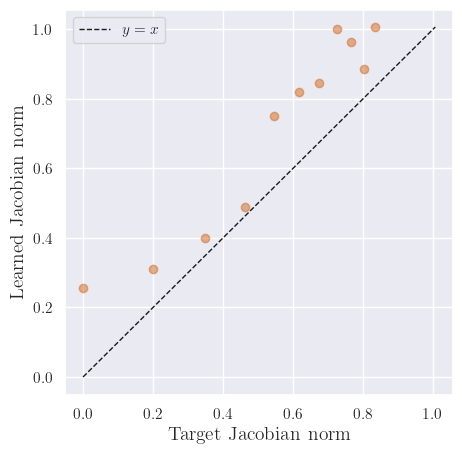

In [6]:
plot_jacobian_norms(df, save_dir_homeo)

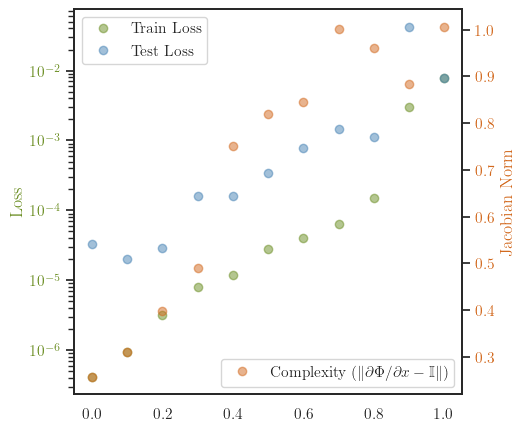

In [7]:
plot_losses_and_jacobian_norms(df, value_name='interpol_value', save_dir=save_dir_homeo, save_name='jacobian_norms.pdf')

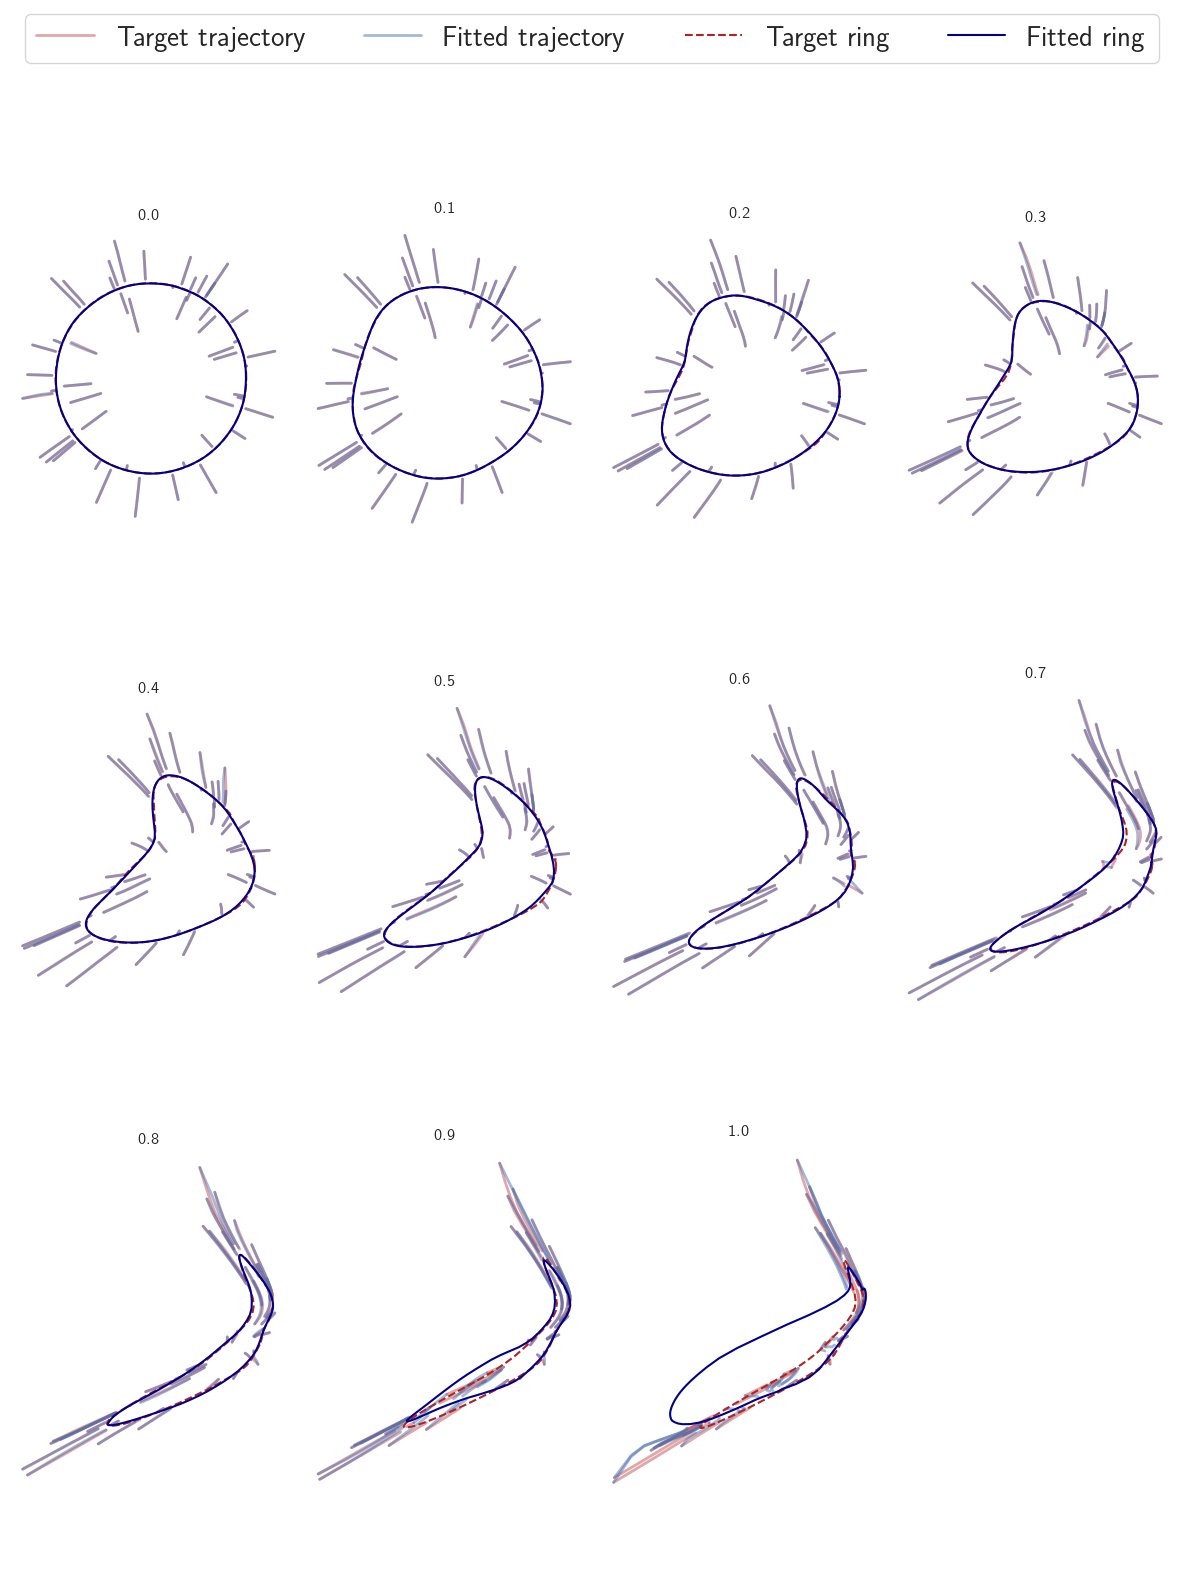

In [8]:
# Select the last 9 entries
last_rows = df.reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(12, 16))
axes = axes.flatten()

# For collecting handles and labels
legend_handles = []
legend_labels = []

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    trajectories_target = np.load(f"{save_dir_homeo}/trajectories_target_{row.interpol_value}.npy")
    l1 = ax.plot(trajectories_target[:, :, 0].T, trajectories_target[:, :, 1].T, 'r-', lw=2, alpha=0.5, label='Target trajectory')
    traj_trans_np = np.load(f"{save_dir_homeo}/traj_motif_transformed_{row.interpol_value}.npy") 
    l2 = ax.plot(traj_trans_np[:, :, 0].T, traj_trans_np[:, :, 1].T, 'b-', lw=2, alpha=0.5, label='Fitted trajectory')

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    l3 = ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], '--', color='firebrick', label='Target RA')
    l4 = ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], '-', color='darkblue', label='Fitted RA')

    # Collect legend handles from first plot only
    if i == 0:
        legend_handles.extend([l1[0], l2[0], l3[0], l4[0]])
        legend_labels.extend(['Target trajectory', 'Fitted trajectory', 'Target ring', 'Fitted ring'])

    ax.set_title(f"{row.interpol_value:.1f}")
    ax.set_aspect('equal')
    ax.axis('off')

axes[-1].axis('off')  
# Add a single global legend
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=4, fontsize='xx-large', )

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f"{save_dir_homeo}/both_trajectories_asy.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
#time length generalization
# length_factor = 10
# maxT_long = maxT/2*length_factor
# tsteps_long = (tsteps-15)*length_factor
# time_span_long = torch.tensor([0.0, time_span[1]*length_factor])
# init_conds_trg = torch.tensor(inv_man, dtype=torch.float32)
# trajectories_source_long, transformed_trajectories_long = generate_trajectories_from_initial_conditions(homeo_ds_net, init_conds_trg, time_span_long)

## Vector field perturbation experiment

In [10]:
def run_pert_ra_experiment(random_seed=313):
    save_dir = "experiments/vf_pert_ring/simple_ra"
    set_seed(random_seed)
    dim = 2
    maxT = 5
    tsteps = maxT*20
    max_perturbation_norm = .15
    pring_simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01,
        "random_seed": 313, "min_val_sim": 3, "n_grid": 40,
        "add_limit_cycle": False,
        "num_points_invman": 200,
        "number_of_target_trajectories": 50, "initial_conditions_mode": "random", "init_margin": 0.25}
    
    ds_motif = 'ring' 
    dt = maxT / tsteps
    time_span = torch.tensor([0.0, maxT])
    analytic = True
    vf_on_ring_enabled = False #if analytic then not used
    training_pairs = False
    alpha_init = None
    if training_pairs:
        time_span = torch.tensor([0.0, dt])
    train_ratio = 0.8
    ds_params = {'ds_motif': ds_motif, 'dim': dim, 'dt': dt, 'time_span': time_span, 'analytic': analytic, 'vf_on_ring_enabled': vf_on_ring_enabled, 'alpha_init': alpha_init}
    simulation_params = {'initial_conditions_mode': 'random', 'number_of_target_trajectories': 50, 'time_span': time_span, 'dt': dt, 'noise_std': .0, 'max_perturbation_norm': max_perturbation_norm,
                        'training_pairs': training_pairs, 'margin': 0.5, 'seed': 42, 'train_ratio': train_ratio, 'ds_params': ds_params, 'pring_simulation_params': pring_simulation_params}
    
    homeo_type = 'node'
    layer_sizes = 1*[128]
    init_type = None
    homeo_params = {'homeo_type': homeo_type, 'dim': dim, 'layer_sizes': layer_sizes, 'activation': nn.ReLU, 'init_type': init_type}

    lr = 0.01
    num_epochs = 1000
    annealing_params = {'dynamic': False, 'initial_std': .0, 'final_std': 0.}
    training_params = {'lr': lr, 'num_epochs': num_epochs, 'annealing_params': annealing_params, 'early_stopping_patience': 1000, "batch_size": 32, 'use_inverse_formulation': True}
    
    all_parameters = { 'homeo_params': homeo_params, 'training_params': training_params, 'simulation_params': simulation_params}
    with open(f"{save_dir}/parameters.pkl", "wb") as f:
        pickle.dump(all_parameters, f)

    
    results = []
    for p_norm in np.arange(0.0, max_perturbation_norm + 0.001, 0.01):  # steps of 0.01
        p_norm = round(p_norm, 2)
        pring_simulation_params['perturbation_norm'] = p_norm
        print(f"Perturbation norm: {p_norm}")
        print("Creating perturbed ring attractor...")
        X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**pring_simulation_params) 
        trajectories_target = torch.tensor(trajectories_pertring, dtype=torch.float32)

        #init homeo_ds_net
        trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target, False)
        inv_man = (inv_man - mean.detach().numpy()) / std.detach().numpy()


        # Plot the trajectories and vector field
        # plot_vector_field_fixedquivernorm_speedcontour(ax, X, Y, U_pert, V_pert, trajectories_pertring, title=f"$\|{p_norm}\|$",
        #                                                scale=1.0, color='teal', alpha=0.5)
        # plot_vector_field_coloredquivernorm(ax, X, Y, U_pert, V_pert, trajectories_pertring, title=f"$\|{p_norm}\|$",
        #                                    traj_color='darkblue', cmap='inferno', save_name=f"{save_dir}/vf_{p_norm}.pdf")
        np.save(f"{save_dir}/trajectories_target_{p_norm}.npy", trajectories_target.detach().numpy())

        B = trajectories_target.shape[0]
        n_train = int(train_ratio * B)
        n_test = B - n_train
        train_set, test_set = random_split(trajectories_target_full, [n_train, n_test])
        trajectories_target_train = trajectories_target[train_set.indices]
        trajectories_target_test = trajectories_target[test_set.indices]

        #train homeo_ds_net
        homeo = build_homeomorphism(homeo_params)
        source_system_ra = build_ds_motif(**ds_params)
        homeo_ds_net = Homeo_DS_Net(homeo, source_system_ra)
        homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train, **training_params)
        homeo_ds_net.eval()
        
        #test
        _, _, training_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_train)
        _, _, test_loss = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_test)
        traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)

        fit_ra_points = get_homeo_invman(homeo_ds_net.homeo_network)
        jac_norm = jacobian_norm_over_batch(homeo_ds_net.homeo_network, trajectories_target.reshape(-1,dim))

        results.append({
            "p_norm": p_norm,
            "train_loss": training_loss,
            "test_loss": test_loss,
            "jacobian_norm": jac_norm,
            "losses": losses,
            "grad_norms": grad_norms,
            "fit_ra_points": fit_ra_points,
            "target_ra_points": inv_man[0],
        })

        save_homeo_ds_net(homeo_ds_net, f"{save_dir}/homeo_{p_norm}.pth")
        np.save(f"{save_dir}/traj_motif_transformed_{p_norm}.npy", traj_trans_np) #save trajectories_motif 
        np.save(f"{save_dir}/traj_motif_source_{p_norm}.npy", traj_src_np) #save trajectories_motif directly from the source 

    df = pd.DataFrame(results)
    df.to_pickle(f"{save_dir}/summary_df.pkl")

In [11]:
#run_pert_ra_experiment() #run time: 6h 43m

In [12]:
#load data
save_dir_pertvf_sra = "experiments/vf_pert_ring/simple_ra"
df = pd.read_pickle(f"{save_dir_pertvf_sra}/summary_df.pkl")

In [13]:
# test models 
# for i, row in df.iterrows():
#     p_norm = row['p_norm']
#     all_parameters = pickle.load(open(f"{save_dir_pertvf_sra}/parameters.pkl", "rb"))
#     layer_sizes = all_parameters['homeo_params']['layer_sizes']
#     alpha_init = all_parameters['simulation_params']['ds_params']['alpha_init']
#     homeo = NODEHomeomorphism(dim=2, layer_sizes=[128], activation=nn.ReLU)        
#     dynsys = AnalyticalRingAttractor(dim=2, alpha_init=None, dt=0.05, time_span=torch.tensor([0.0, 5.]))
#     homeo_ds_net = load_homeo_ds_net(f"{save_dir_pertvf_sra}/homeo_{p_norm}.pth", homeo, dynsys)
#     homeo_ds_net.eval()
#     trajectories_target = np.load(f"{save_dir_pertvf_sra}/trajectories_target_{row.p_norm}.npy")
#     trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32)
#     traj_src_np, traj_trans_np, _ = test_single_homeo_ds_net(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target)

#     np.save(f"{save_dir_pertvf_sra}/traj_motif_transformed_{p_norm}.npy", traj_trans_np) 
#     np.save(f"{save_dir_pertvf_sra}/traj_motif_source_{p_norm}.npy", traj_src_np) #save trajectories_motif directly from the source 


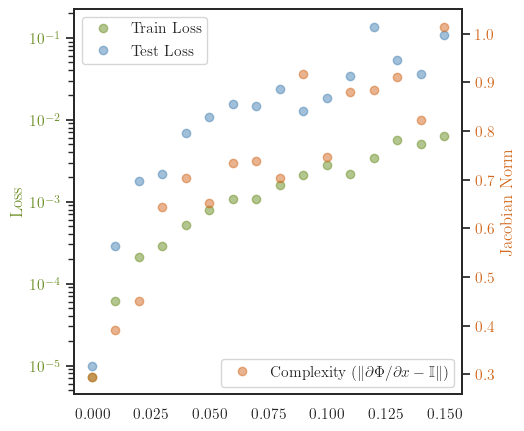

In [14]:
plot_losses_and_jacobian_norms(df, value_name='p_norm', save_dir=save_dir_pertvf_sra, save_name='jacobian_norms.pdf')

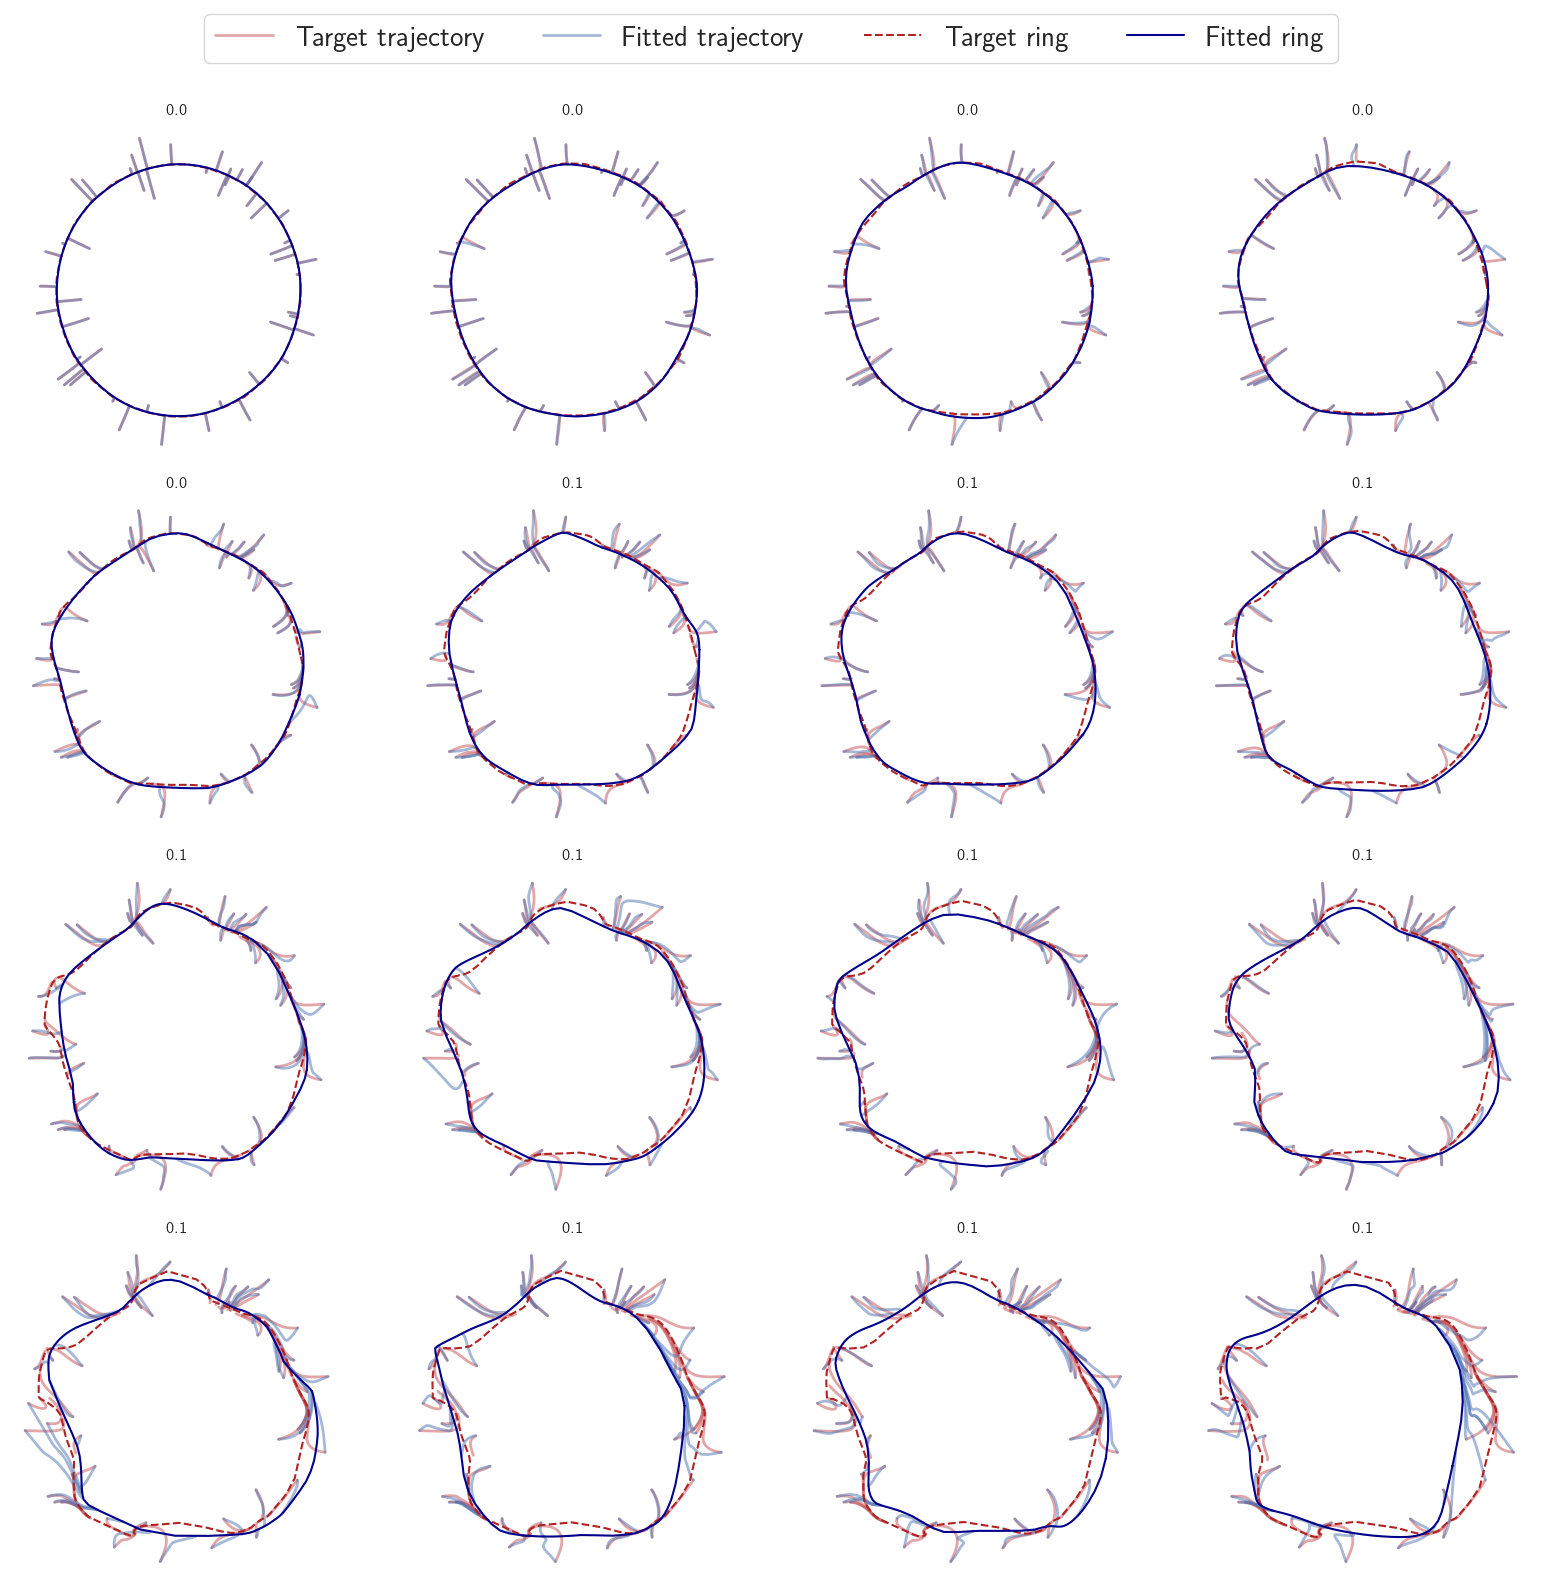

In [15]:
# Select the last 9 entries
last_rows = df.reset_index(drop=True)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

# For collecting handles and labels
legend_handles = []
legend_labels = []

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    trajectories_target = np.load(f"{save_dir_pertvf_sra}/trajectories_target_{row.p_norm}.npy")
    l1 = ax.plot(trajectories_target[:, :, 0].T, trajectories_target[:, :, 1].T, 'r-', lw=2, alpha=0.5, label='Target trajectory')
    traj_trans_np = np.load(f"{save_dir_pertvf_sra}/traj_motif_transformed_{row.p_norm}.npy") 
    l2 = ax.plot(traj_trans_np[:, :, 0].T, traj_trans_np[:, :, 1].T, 'b-', lw=2, alpha=0.5, label='Fitted trajectory')

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    l3 = ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], '--', color='firebrick', label='Target RA')
    l4 = ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], '-', color='darkblue', label='Fitted RA')

    # Collect legend handles from first plot only
    if i == 0:
        legend_handles.extend([l1[0], l2[0], l3[0], l4[0]])
        legend_labels.extend(['Target trajectory', 'Fitted trajectory', 'Target ring', 'Fitted ring'])

    ax.set_title(f"{row.p_norm:.1f}")
    ax.set_aspect('equal')
    ax.axis('off')

# Add a single global legend
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=4, fontsize='xx-large')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f"{save_dir_pertvf_sra}/both_trajectories_asy.pdf", dpi=300, bbox_inches='tight')
plt.show()
